<a href="https://colab.research.google.com/github/sebsatian/Control2TBD/blob/main/Copy_of_Summarization_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalamos "gdown" para poder descargar un video desde GDrive

In [ ]:
!pip install gdown

Decargamos un video y lo visualizamos

In [ ]:
import gdown
id='18nFYkV0NT53AXTh1P08TvkziT2RFL_o0'
gdown.download(id=id, output='test2.mp4')

Downloading...
From: https://drive.google.com/uc?id=18nFYkV0NT53AXTh1P08TvkziT2RFL_o0
To: /content/test2.mp4
100%|██████████| 501k/501k [00:00<00:00, 7.13MB/s]


'test2.mp4'

In [ ]:
from moviepy.editor import *

path="test2.mp4"

clip=VideoFileClip(path)
clip.ipython_display(width=280)

  if event.key is 'enter':



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Importamos OpenCV para leer el video y obtener sus frames

In [ ]:
import cv2

Leemos todos los frames del video y los almacenamos en una lista

In [ ]:
vid_capture = cv2.VideoCapture('test2.mp4')
if vid_capture.isOpened == False:
  print('Error leyendo el video')

#Leemos todos los frames
frames = []

while vid_capture.isOpened():
  ret, frame = vid_capture.read()
  if ret == True:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
  else:
    break

vid_capture.release()

In [ ]:
# La cantidad de frames
print(len(frames))

171


Haremos uso de Pytorch para describir los frames con una red neuronal convolucional.

In [ ]:
import torch #Librería Pytorch
import torchvision #Módulo para visión computacional de Pytorch
import torchvision.transforms as T #Módulo para transformaciones de imágenes
from PIL import Image #Módulo para leer imágenes
import matplotlib.pyplot as plt
import numpy as np

Estas transformaciones preparan el input para la red neuronal. En este caso se aplican las transformaciones:


*   Resize(256): redimensiona el frame de tal manera que el lado más corto tenga 256 píxeles
*   CenterCrop(224): realiza un recorte de un parche de 224x224
*   ToTensor: Convierte el frame a un tensor de Pytorch y normaliza sus valores entre 0 y 1
*   Normalize: normaliza la distribución de los píxeles de acuerdo a la estadística de ImageNet (dataset con el que fue entrenada la red que usaremos)



In [ ]:
transform=T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor(),T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

Cargamos una ResNet18 preentrenada. La ponemos en modo evaluación, ya que solo haremos inferencias. Enviamos la red al GPU

In [ ]:
#Cargar modelo pre-entrenado
model = torchvision.models.resnet18(pretrained=True)

#Habilitar el modo de evaluación que mejora el performance para la inferencia
model.eval()
model.to('cuda') #Mandamos el modelo al GPU

  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Aquí creamos una función especial que captura el feature que se calcula en la capa que se llama "avgpool". Esta capa es la penúltima capa de ResNet, antes de que se haga alguna clasificación. La idea de este procedimiento es que capturemos las features y las guardemos en una lista que usaremos después

In [ ]:
# Lista para capturar la información de la penúltima capa
features = []

#Esta función captura la salida de una operación llamada AvgPool, la última operación
#antes de pasar a la clasificación

def hook_feature(module, input,output):
  data = output.data.cpu()
  data = torch.flatten(data, 1)
  features.append(data.numpy())

# Registramos la función espía en el módulo de la red neuronal
model._modules.get('avgpool').register_forward_hook(hook_feature)

Recorremos cada frame y lo enviamos a la red neuronal. Internamente se están calculando los descriptores y se están guardando en "features"

In [ ]:
for frame in frames:
  #Transformando a PIL image ya que Opencv tiene todo en Numpy
  img = Image.fromarray(frame)
  #Aplicar las transformaciones definidas arriba
  input = transform(img)
  #Un frame lo conviertes a una representación batch, ej (224,224,3) => (1,224,224,3)
  input = input.unsqueeze(0)
  out = model(input.to('cuda'))


Tomamos las features y las convertimos a un array que tendrá tamaño (num_frames x dimension)

In [ ]:
desc = np.vstack(features)
print(desc.shape)

(171, 512)


Usaremos el K-Means que viene implementado en Scikit Learn

In [ ]:
from sklearn.cluster import KMeans

Aquí hacemos el clustering de los descriptores que están almacenados en "desc". Le pedimos tres clusters

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(desc)

Hay algo interesante! Cuando dibujamos las etiquetas que se asignan a cada descriptor (por su cercanía a los centroides), nos damos cuenta que se clusterizaron los descriptores por su semejanza y automáticamente se perciben shots en el video

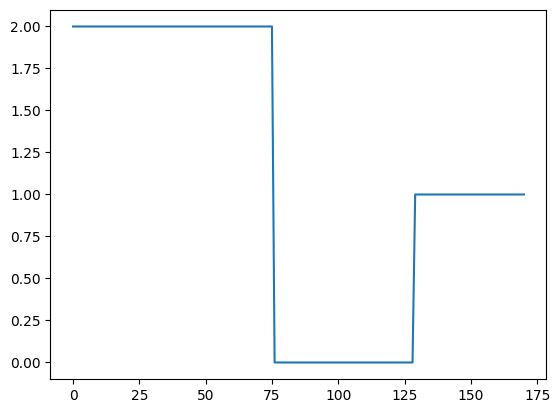

In [ ]:
plt.plot(kmeans.labels_)
plt.show()

In [ ]:
#Encontrar los frames más parecidos a los centroides
print(kmeans.cluster_centers_.shape)

(3, 512)


Ahora tenemos que calcular la distancia de cada centroide a los descriptores del video. Esto para poder encontrar el descriptor del frame que más se parece al centroide y usarlo como keyframe.

In [ ]:
from scipy.spatial.distance import cdist

distances = cdist(kmeans.cluster_centers_, desc) #Calcula la distancia de cada centroide con cada descriptor
min_indices = np.argmin(distances, axis=1) #Encuentra la distancia mínima para cada centroide y reporta el índice en donde ocurre el mínimo
min_indices

array([ 84, 155,  12])

Dibujamos los frames que son los más parecidos a los centroides

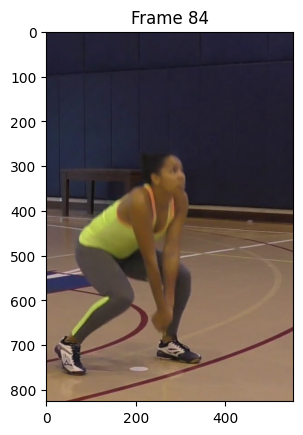

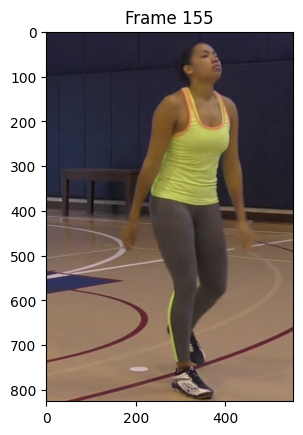

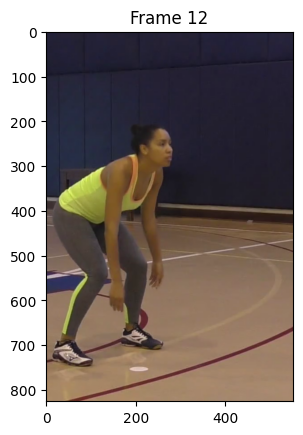

In [ ]:

for index in min_indices:
  plt.imshow(frames[index])
  plt.title(f"Frame {index}")
  plt.show()